In [9]:

from scipy.stats import norm
import numpy as np
import torch
import sobol_seq
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, metrics
from keras import metrics
from sklearn.model_selection import train_test_split

In [10]:
def bsPrice(x):
    spot, strike, vol, T, r = x
    d1 = (np.log(spot/strike) + (r+vol * vol / 2.)*T )/ vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)*np.exp(-r*T)
def delta(x):
    spot, strike, vol, T, r = x
    d1 = (np.log(spot/strike) + (r+vol * vol / 2.)*T )/ vol / np.sqrt(T)
    return norm.cdf(d1)

In [18]:
N = 50000
seq = sobol_seq.i4_sobol_generate(4, N)
Slist = seq[:,0]
Klist = seq[:,1]*1.5
vollist = seq[:,2]*0.9+0.1
Tlist = seq[:,3]*2+1/12


data = np.zeros((N,5))
for i in range(N):
    x = Slist[i], Klist[i], vollist[i], Tlist[i], 0
    data[i,0] = Slist[i]
    data[i,1] = Klist[i]
    data[i,2] = vollist[i]
    data[i,3] = Tlist[i]
    data[i,4] = bsPrice(x)




In [19]:
# split into input(X) and output (y) variables
X = data[:,0:4]
y = data[:,4]

# split test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.1, random_state=42)

In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


In [21]:
# define Keras model (from https://hpcquantlib.wordpress.com/2019/10/12/almost-exact-sabr-interpolation-using-neural-networks-and-gradient-boosted-trees/)
model = Sequential()
model.add(Dense(20, activation='linear', input_shape=(4, )))
model.add(Dense(100, activation='linear'))
model.add(Dense(400, activation='softplus'))
model.add(Dense(10, activation='softplus'))
model.add(Dense(1, activation='softplus'))

In [22]:
# compile the model
opt = optimizers.Adam(learning_rate=0.01)
m = metrics.MeanSquaredError()
model.compile(loss='mae', optimizer=opt,metrics=[m])
# fit the model
model.fit(X_scaled, y_train, epochs=120, batch_size=50)

Epoch 1/120
900/900 [==============================] - 1s 558us/step - loss: 0.0280 - mean_squared_error: 0.0098

In [23]:
#evaluate the model
loss, mse = model.evaluate(scaler.transform(X_test), y_test, verbose=0)
print('MSE: %.9f' % (mse))



MSE: 0.000109618


<ipython-input-10-e805d2905738>:8: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(spot/strike) + (r+vol * vol / 2.)*T )/ vol / np.sqrt(T)


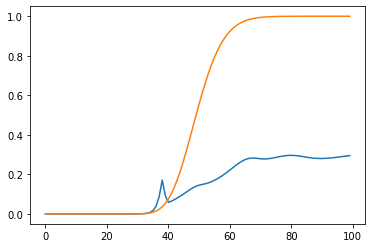

In [24]:
import tensorflow as tf
inputdata = np.zeros((100,4))
inputdata[:,0] = np.linspace(0,1,100)
inputdata[:,1] = 0.5
inputdata[:,2] = 0.2
inputdata[:,3] = 0.5

x_tensor = tf.convert_to_tensor(scaler.transform(inputdata), dtype=tf.float32)
with tf.GradientTape() as t:
    t.watch(x_tensor)
    output = model(x_tensor)

result = output
gradients = t.gradient(output, x_tensor)

import matplotlib.pyplot as plt
plt.plot(gradients[:,0])

deltalist = np.zeros((100,))
for i in range(100):
    x = inputdata[i,0],inputdata[i,1], inputdata[i,2], inputdata[i,3],0
    deltalist[i] = delta(x)

plt.plot(deltalist)